## Load libraries and functions

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
# import the KMeans clustering model from scikit-learn
import matplotlib.pyplot as plt

from myVAR import myVAR,adfuller_test,plot_vars,plot_comparison

import warnings
warnings.filterwarnings('ignore')

## Instantiate a VAR with parameters

In [2]:
df=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/var_data_COMPLETE.csv',index_col='Year')
countryList=df['Country'].unique() #37 countries
nobsList=[1,2,3,4]
diff_orderList=[1,2]
pList=[1,2,3,4]

- Bad country (by Python index)
  - 1 AFG
- Bad nobs
- Bad diff_order
- Bad p

------------------------------
Country::nobs::diff_order::forecast_steps::p
China 1 1 9 1
------------------------------
1 6.299496377121132
ERROR: CANNOT FIT DURING LAG INSPECTION
3 -273.243605278504
4 -276.1487955272913
5 -294.6213138317394
------------------------------
Country::nobs::diff_order::forecast_steps::p
China 1 2 9 1
------------------------------
1 7.587184317764241
ERROR: CANNOT FIT DURING LAG INSPECTION
3 -278.7431725204021
4 -291.0576242596741
5 -297.78777289480274


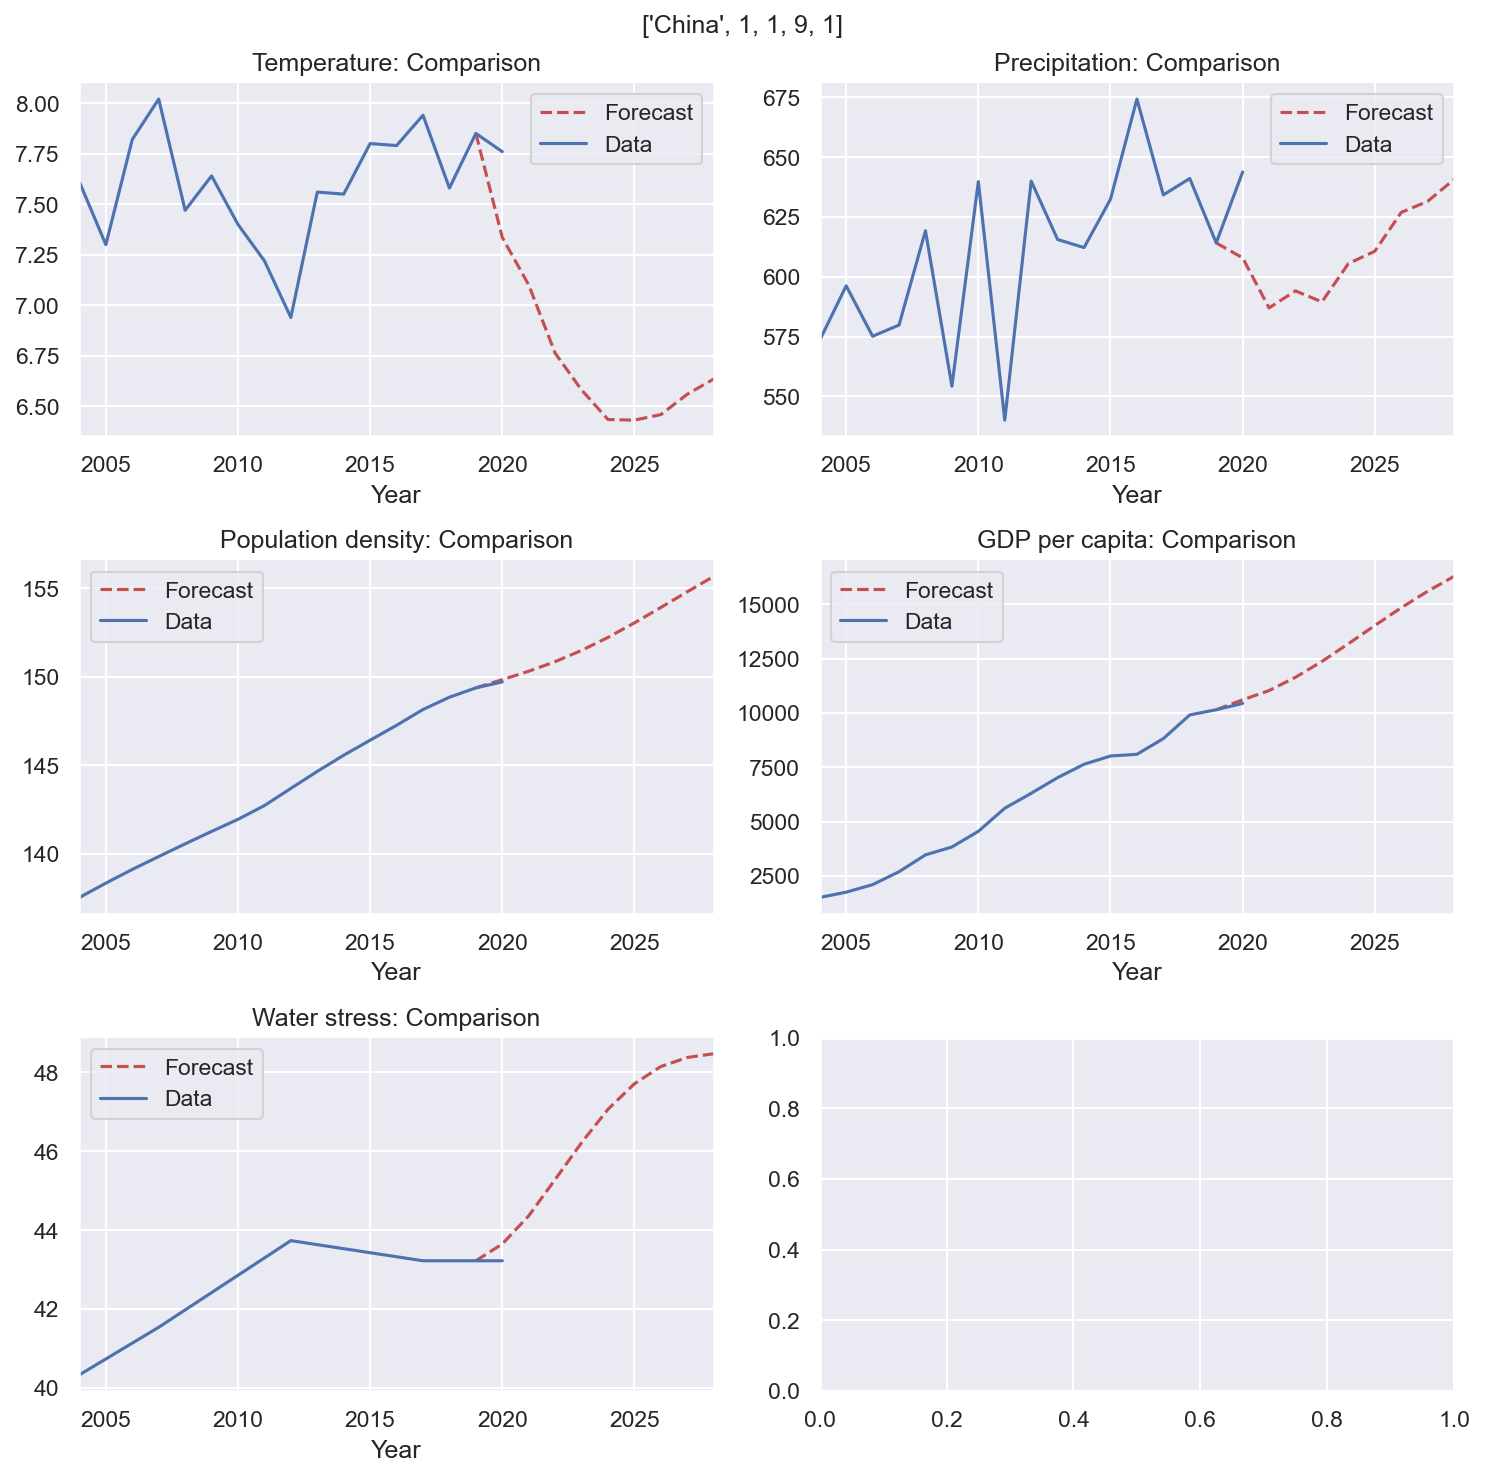

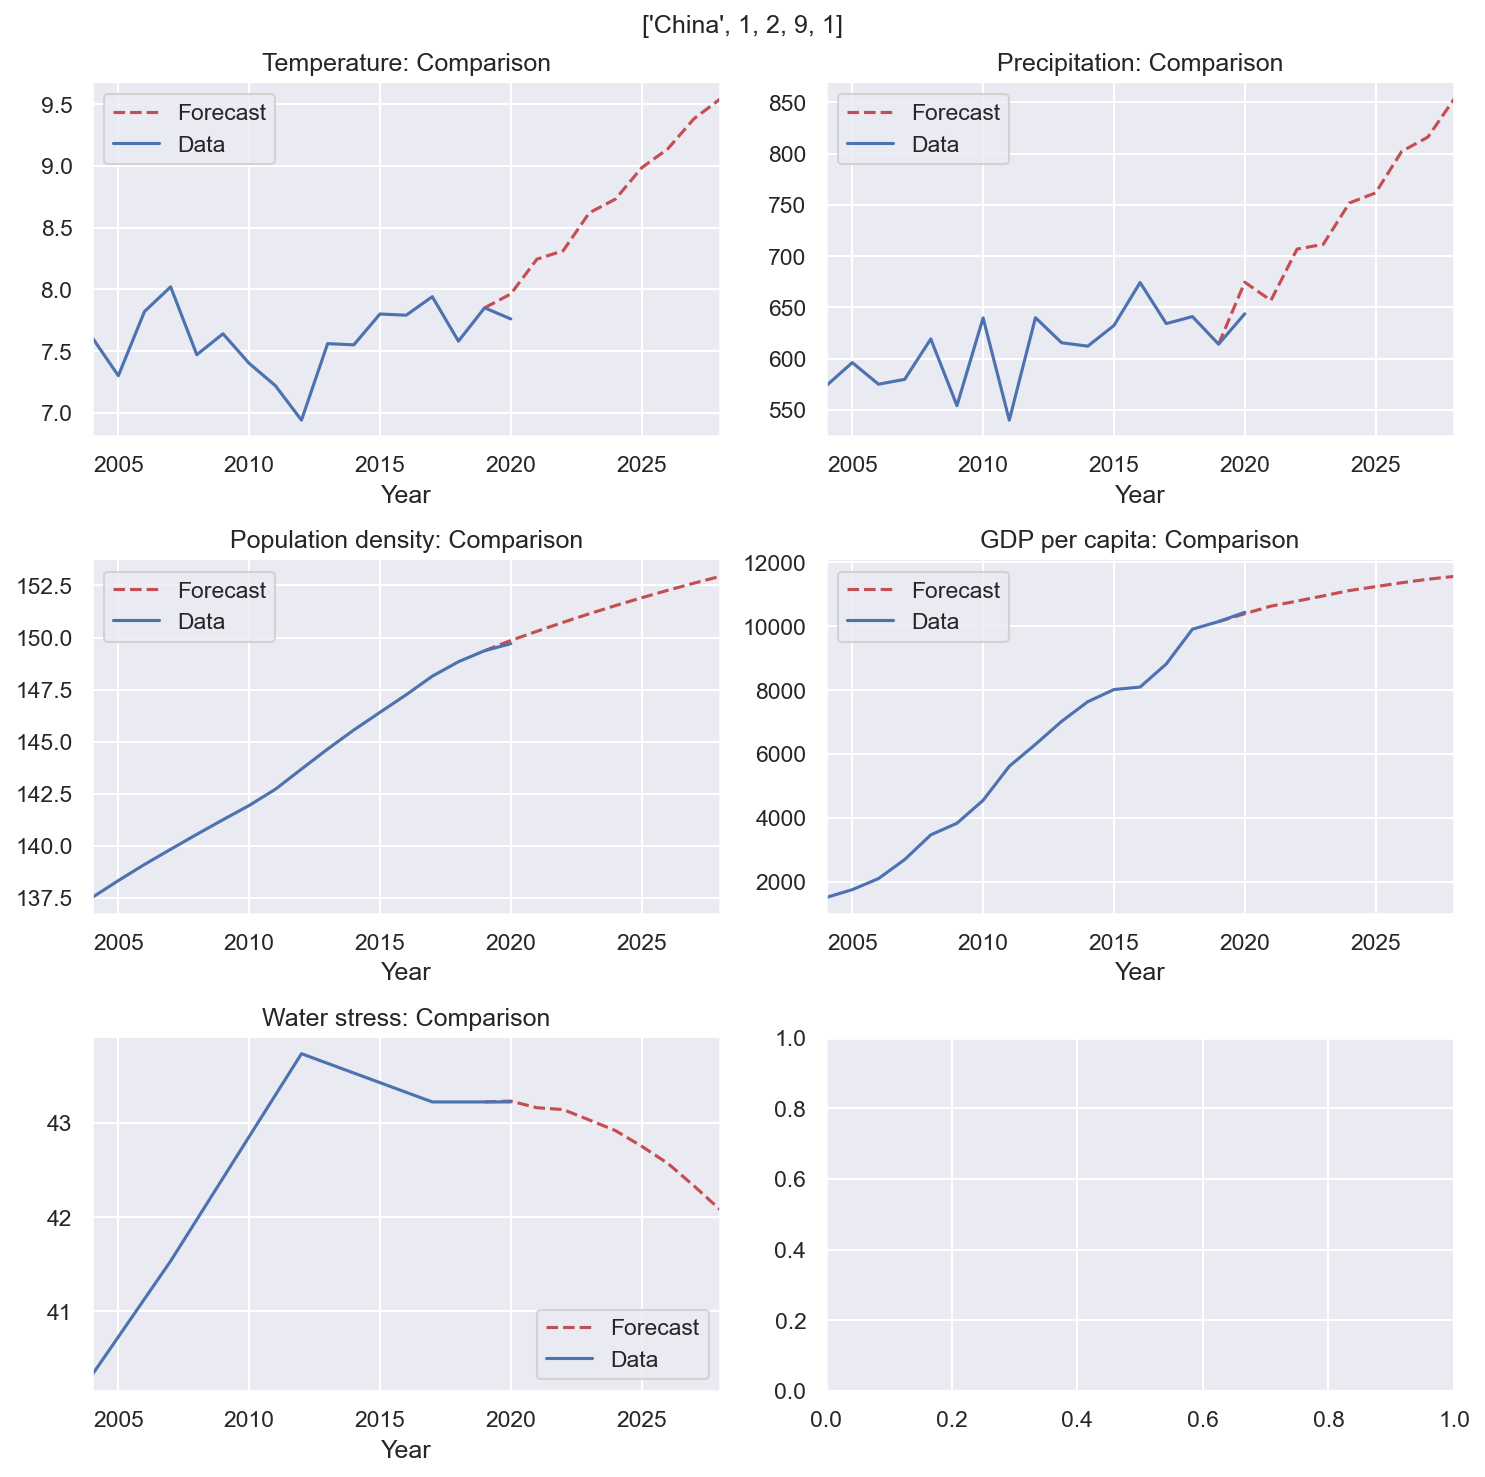

In [3]:
def generate_result(country,nobs,diff_order,forecast_steps,p):
    # load the data
    ts=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/var_data_COMPLETE.csv',index_col='Year')
    # ts.drop(columns=['Temperature (annual mean)','Population density (people per sq. km of land area)'],inplace=True)
    ts=ts.loc[ts['Country'] == country]
    ts.drop(columns=['Country'],inplace=True)
    ts.interpolate(method='linear', axis=0,inplace=True)

    v1=myVAR(ts)
    # split
    v1.ts_split(nobs)
    # difference
    v1.ts_train_diff=v1.get_diff(v1.ts_train,diff_order,verbose=False)
    # granger
    # granger_result=v1.granger_matrix()
    # plt.figure(figsize=(6,5));sns.heatmap(granger_result,annot=True, linewidths=.5, vmax=.05)
    # cointegration
    # v1.cointegration_test()
    # lag and fit
    v1.inspect_lag(5)
    v1.fit = v1.get_fit(p)
    v1.fit.summary()
    # serial correlation
    # v1.check_serial_correlation(plot=True)
    # forecast diff
    v1.ts_forecast_diff,v1.ts_forecast_diff.lower,v1.ts_forecast_diff.upper=v1.get_forecast_diff(forecast_steps,plot=False)
    # real forecast (invert)
    v1.ts_forecast = v1.get_inv_diff(v1.ts_forecast_diff,diff_order)
    v1.ts_forecast.lower = v1.get_inv_diff(v1.ts_forecast_diff.lower,diff_order)
    v1.ts_forecast.upper = v1.get_inv_diff(v1.ts_forecast_diff.upper,diff_order)
    v1.ts_forecast.head()
    # results
    v1.ts_results=pd.concat([v1.ts_train,v1.ts_forecast])
    v1.ts_results.lower=pd.concat([v1.ts_train,v1.ts_forecast.lower])
    v1.ts_results.upper=pd.concat([v1.ts_train,v1.ts_forecast.upper])
    # v1.ts_results.tail()
    return v1

for diff_order in diff_orderList:
# if country in ['Afghanistan']:
# print("DATA IS NOT VALID - CHANGE COUNTRY")
# continue
    country=countryList[0]
    nobs=1 #parameter
    # diff_order=2 #parameter
    forecast_steps=9 #parameter
    p=1 #parameter
    print('-'*30)
    print('Country::nobs::diff_order::forecast_steps::p')
    print(country,nobs,diff_order,forecast_steps,p)
    print('-'*30)

    try:
        v1=generate_result(country,nobs,diff_order,forecast_steps,p)
        plot_comparison(v1,
            steps=forecast_steps,
            name=str([country,nobs,diff_order,forecast_steps,p]),
            interval=True,
            figsize=(10,10))
        error=v1.get_forecast_error(v1.ts_forecast)
        error
        # error.loc[['RMSE'],['Water stress']]
    except:
        # print("ERROR: PARAMETER NOT SUITABLE")
        pass